<a href="https://colab.research.google.com/github/saisriy/ShroudX/blob/main/Image_in_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Necessary Libraries

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [129]:
def Read_image(image_path) :
    image = cv2.imread(image_path)
    return image

def Write_image(image_path,image) :
    cv2.imwrite(image_path,image)

def Show_image(image,title) :
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()


def resize_image(image_path, output_path, width, height) :
    image = Read_image(image_path)
    resized_image = cv2.resize(image, (width, height))
    Write_image(output_path, resized_image)
    print(f"Resized image saved to {output_path}")


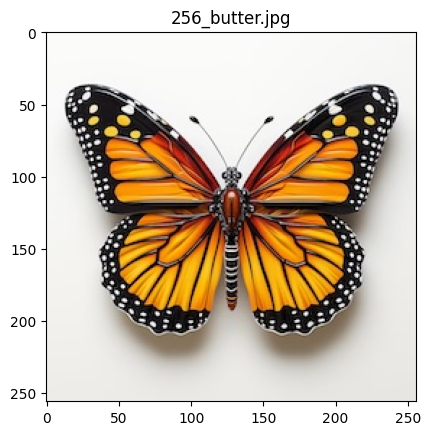

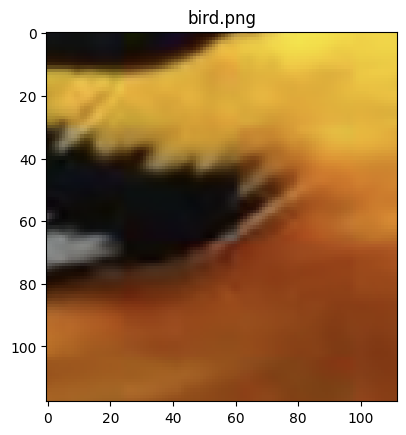

In [130]:
img = Read_image('256_butter.jpg')
Show_image(img,'256_butter.jpg')

im = Read_image('bird.png')
Show_image(im,'bird.png')

In [131]:
'''
  Converts each value into 8-bit binary representation
'''
def image_to_binary_3D(image):
    binary_image = np.vectorize(lambda x: format(x, '08b'))(image)
    return binary_image

In [132]:
'''
    Store corresponging index's value in a list
'''
def each_bit(binary_image,index,height,width,color) :
    matrix =[]
    for i in range(height) :
      Line = []
      for j in range(width) :
        cell = []
        for k in range(color) :
          cell.append(binary_image[i][j][k][index])
        Line.append(cell)
      matrix.append(Line)
    return matrix


In [133]:
def Divider(binary_matrix) :
    matrix = []
    height, width, color = binary_matrix.shape

    for i in range(8) :
      matrix.append(each_bit(binary_matrix,i,height,width,color))
    return matrix

In [134]:
def Combiner(index_1,index_2,Matrix,binary_matrix) :
    matrix = []
    height, width, color = binary_matrix.shape

    for i in range(height):
      Line = []
      for j in range(width) :
        cell = []
        for k in range(color) :
          unit = ''
          for l in range(index_1,index_2+1) :
            unit += Matrix[l][i][j][k]
          for x in range(7-index_2+index_1) :
            unit += '0'

          cell.append(unit)
        Line.append(cell)
      matrix.append(Line)
    return matrix

In [135]:
def binary_to_int(binary_string) :
  return int(binary_string, 2)

In [136]:
def making_to_int(binary_matrix) :
    height,width,color = binary_matrix.shape
    number_matrix = []
    for i in range(height) :
       Line = []
       for j in range(width) :
          cell = []
          for k in range(color) :
            unit = binary_to_int(binary_matrix[i][j][k])
            cell.append(unit)
          Line.append(cell)
       number_matrix.append(Line)

    return number_matrix

In [137]:
def ENcode_lsb(cover_path, secret_path_1,secret_path_2, output_path) :

    cover = Read_image(cover_path)
    height, width = secret_path_1.shape[:2]
    cover_height, cover_width = cover.shape[:2]

    if height > cover_height or width > cover_width/2 :
        raise ValueError("stego capacity maximum level reached. Resize it or use a smaller secret.")

    cover_masked = cover.copy()
    cover_masked[0:height, 0:2*width] = cover_masked[0:height, 0:2*width] & 0b11111000


    secret_masked_1 = (secret_path_1 >> 5).astype(np.uint8)

    secret_masked_2 = (secret_path_2 >> 5).astype(np.uint8)

    for i in range(height) :
        for j in range(width) :
                cover_masked[i, 2*j] |= secret_masked_1[i, j]

                cover_masked[i, 2*j+1] |= secret_masked_2[i, j]



    Write_image(output_path, cover_masked)

    print(f"Stego image saved as {output_path}")

    return height,width


def DEcode_lsb(stego_path, output_path, secret_size) :

    stego = Read_image(stego_path)
    height, width = secret_size

    secret_1 = np.zeros((height, width, 3), dtype=np.uint8)
    secret_2 = np.zeros((height, width, 3), dtype=np.uint8)

    for i in range(height) :
        for j in range(2*width) :
            if  j % 2 == 0:
                k = int(j/2)
                secret_1[i, k] = (stego[i, j] & 0b00000111) << 5
            else:
                k = int((j-1)/2)
                secret_2[i, k] = (stego[i, j] & 0b00000111) << 2

    reconstruct(secret_1,secret_2,output_path)


def reconstruct(secret_image_1, secret_image_2, output_path) :
    """
    Combines pixels from two secret images to construct a new image.

    """

    height_1, width_1 = secret_image_1.shape[:2]
    height_2, width_2 = secret_image_2.shape[:2]

    if height_1 != height_2 or width_1 != width_2:
        raise ValueError("Secret images must have the same dimensions. Error Occured in the process")

    recombined_image = np.zeros_like(secret_image_1)

    for i in range(height_1) :
        for j in range(width_1) :
                recombined_image[i, j] = secret_image_1[i, j] + secret_image_2[i, j]

    Write_image(output_path, recombined_image)
    print(f"Reconstructed image saved as {output_path}")


In [138]:
def start_Encode(cover_path,secret_path,stego_path) :
    cover_image = Read_image(cover_path)
    secret_image = Read_image(secret_path)
    Binary_secret = image_to_binary_3D(secret_image)
    Bitted_secret = Divider(Binary_secret)
    Secret_1 = Combiner(0,2,Bitted_secret,Binary_secret)
    Secret_2 = Combiner(3,5,Bitted_secret,Binary_secret)
    Secret_1 = np.array(Secret_1)
    Secret_2 = np.array(Secret_2)
    change_11 = making_to_int(Secret_1)
    change_22 = making_to_int(Secret_2)
    change_11 = np.array(change_11)
    change_22 = np.array(change_22)

    code = ENcode_lsb(cover_path,change_11,change_22,stego_path)
    return code

In [139]:
key = start_Encode('256_butter.jpg','bird.png','stego.png')
DEcode_lsb('stego.png','retrived.png',key)

Stego image saved as stego.png
Reconstructed image saved as retrived.png


Width of the Secret Image should be less than or equal to half of width of Cover Image <br>
Height of the Secret Image should be less than or equal to height of Cover Image